In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from utils import move_last_two_months_first, load_example_decadal_means, load_example_genesis_frequency

def make_example_single_figure(val, vmin=None, vmax=None):

    fig, ax = plt.subplots(figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)

    ax.add_feature(land_feature)
    ax.add_feature(countries_feature)
    ax.add_feature(states_provinces, edgecolor='gray')

    #ax.set_xticks([])
    #ax.set_yticks([])

    # Plot gradient for model prediction on top of the land feature
    lonplot2 = np.linspace(135, 240, val.shape[1])
    latplot2 = np.linspace(-5, -60, val.shape[0])
            
    # Use a continuous colormap
    contour = ax.contourf(lonplot2, latplot2, val, levels=100, cmap=cmocean.cm.matter, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
            
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-180, -160, -140, -90, -45, 0, 45, 90, 140, 160, 180, 225, 270, 315, 360])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 30, 'color': 'black'}
    gl.ylabel_style = {'size': 30, 'color': 'black'}
            
    # Adjust map extent to focus on the region of interest
    ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(contour, ax=ax)
    cbar.ax.tick_params(labelsize=30)
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.show()
    

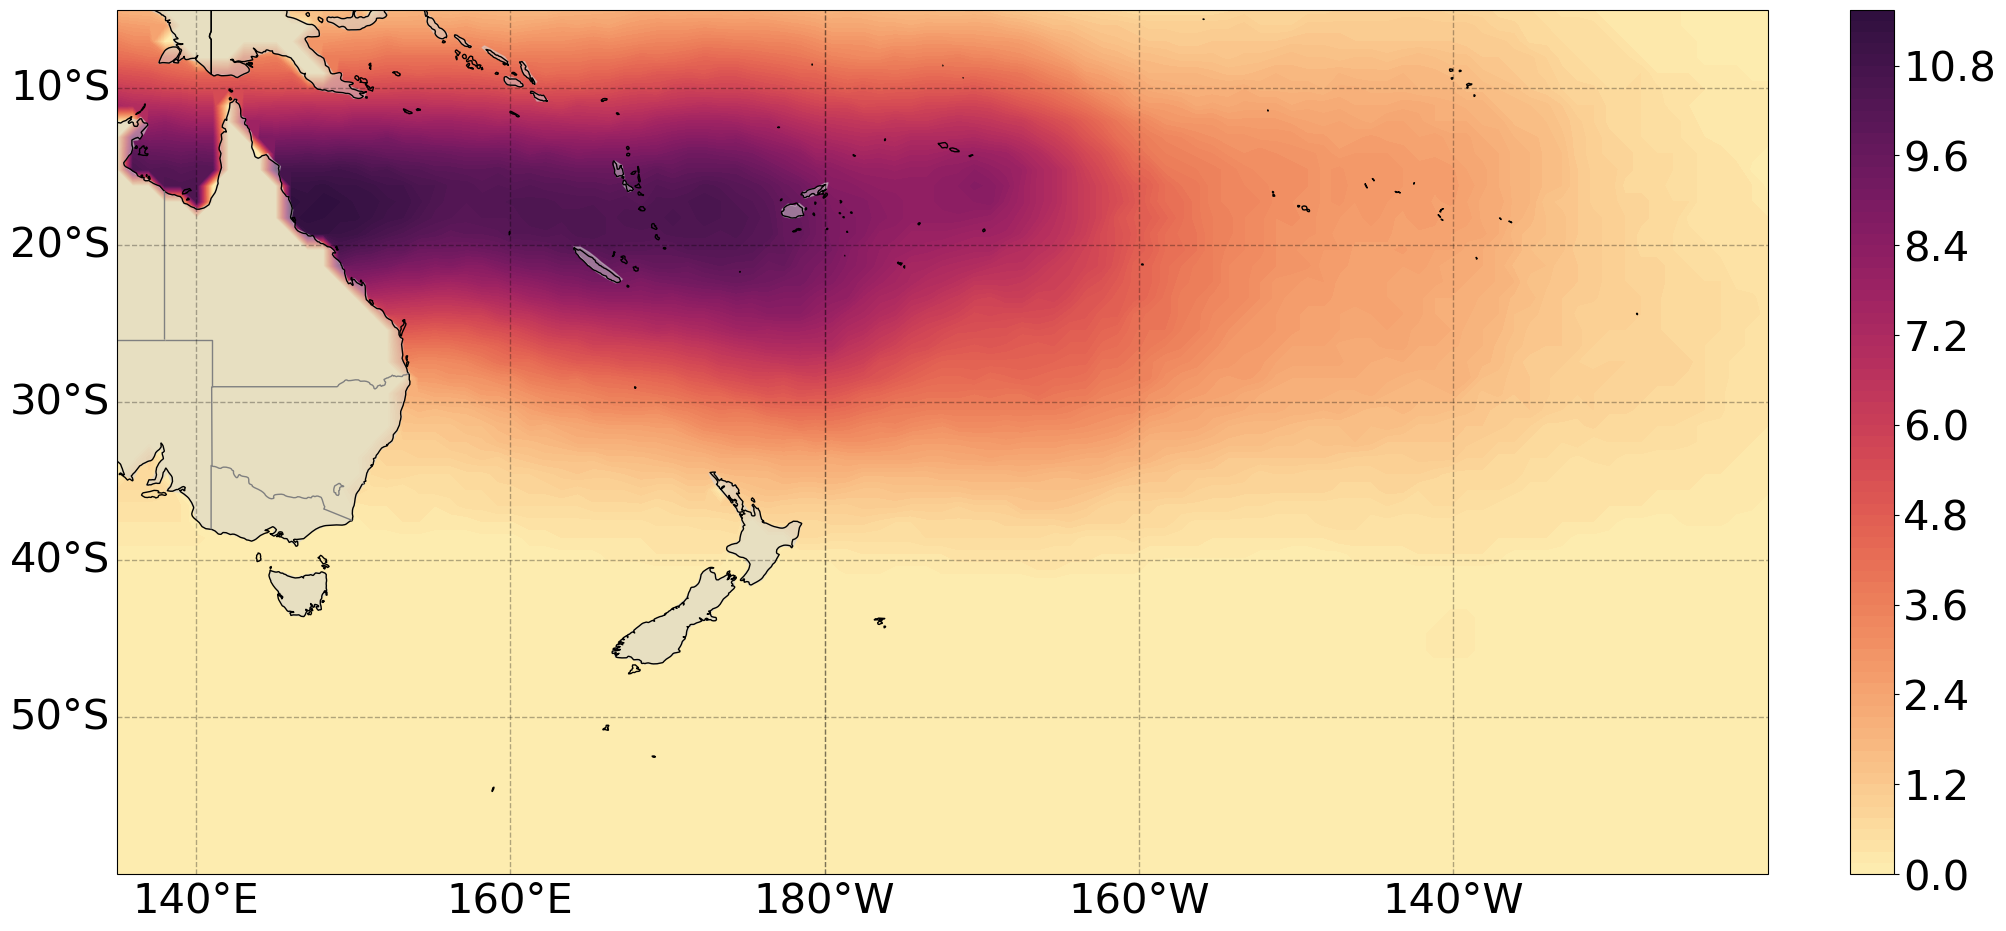

In [33]:
data_folder  = "/users/ewinkelm/data/ewinkelm/"

genesis = load_example_genesis_frequency(data_folder, sum_months=True)

make_example_single_figure(genesis)

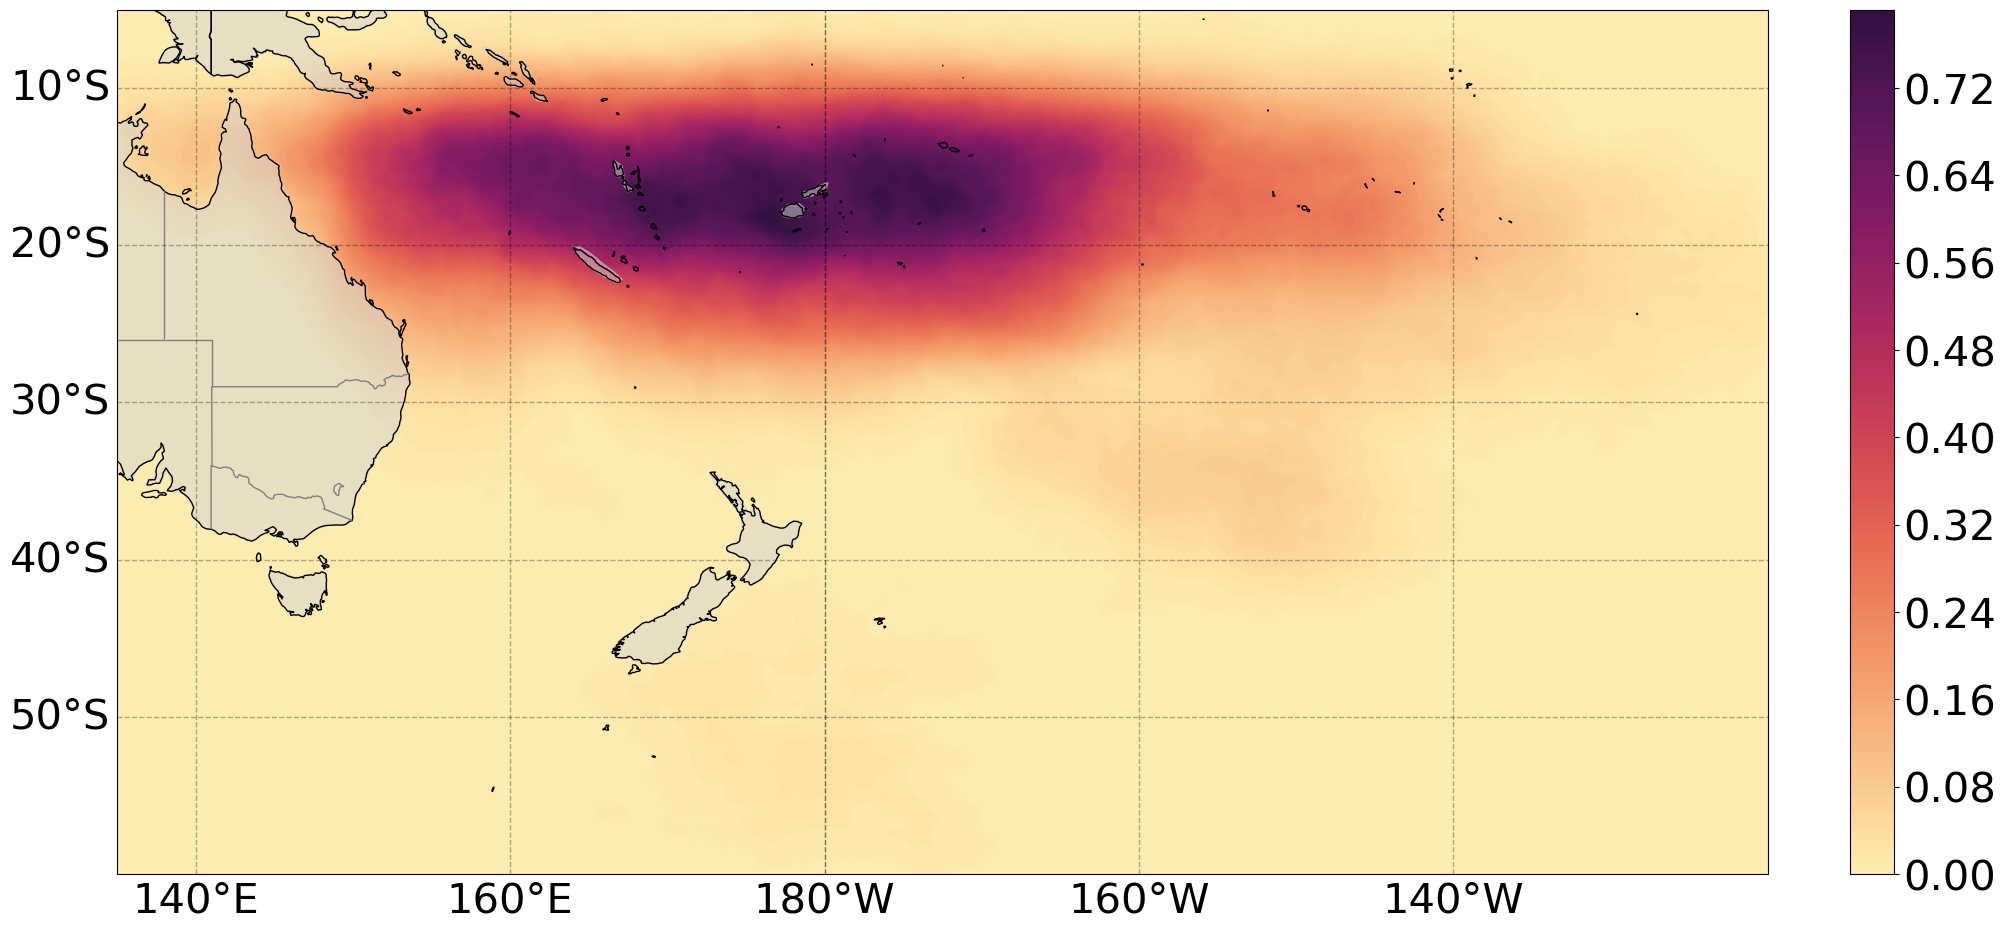

In [34]:
mean_counts = load_example_decadal_means(data_folder)
make_example_single_figure(mean_counts, vmin=0, vmax=0.8)

In [19]:
from saved_models.saved_models import FNO_model
from MachineLearning.dataset import normalize_input
import torch
model = FNO_model()

genesis = load_example_genesis_frequency(data_folder, sum_months=False)
# add channel dimension and normalize
preprocessed_genesis = torch.from_numpy(np.array([model.preprocess_input(genesis)]))
print(preprocessed_genesis.shape)
prediction = model(preprocessed_genesis)

2024-12-02 11:41:27.030070: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 11:41:28.555735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 11:41:28.555818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 11:41:28.855444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 11:41:29.462588: I tensorflow/core/platform/cpu_feature_guar

(1, 110, 210)
torch.Size([1, 1, 110, 210])


(1, 110, 210)


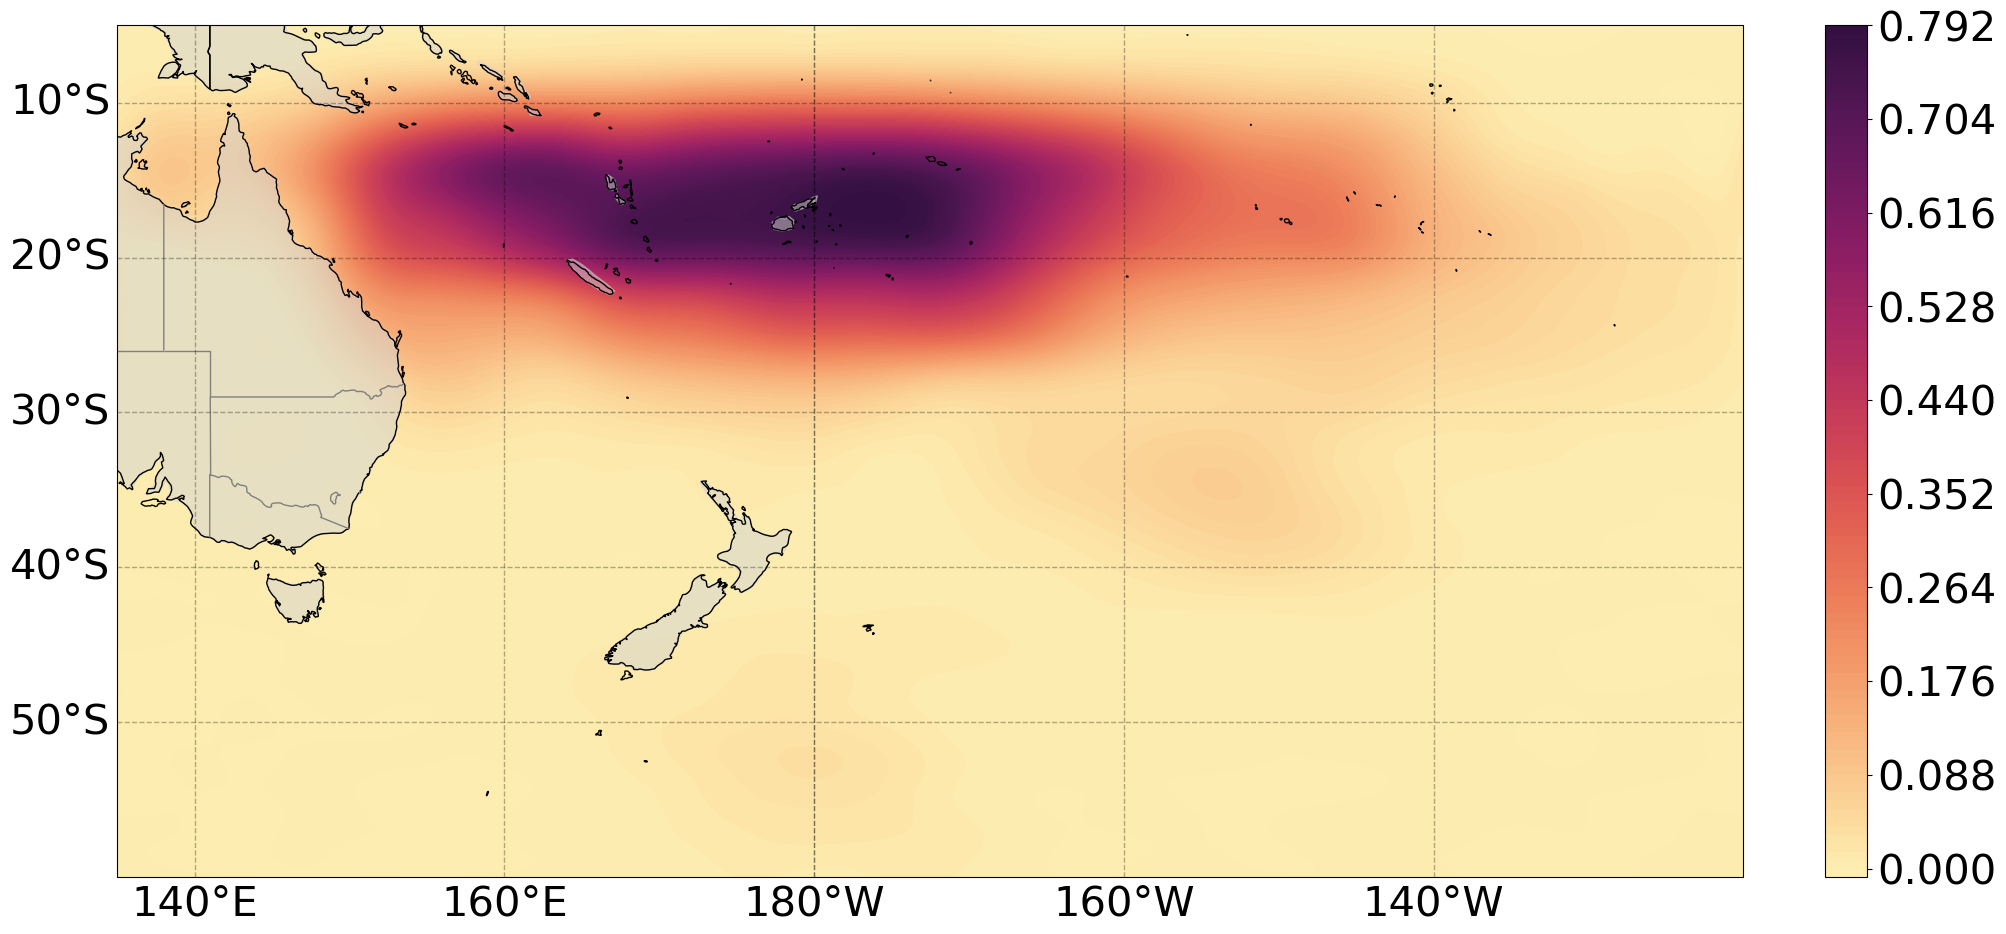

In [35]:
print(prediction.shape)
make_example_single_figure(prediction[0], vmin=0, vmax=0.8)

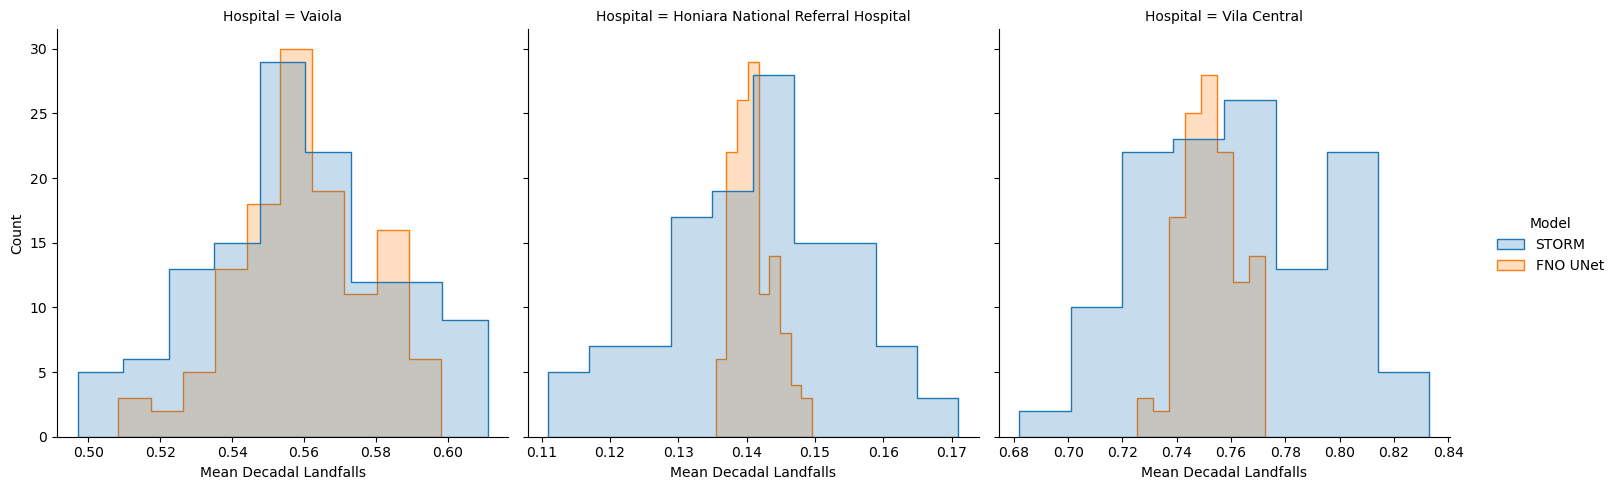

In [3]:
import pandas as pd
import seaborn as sns

## taken from MachineLearning.Evaluation.figures make_example_site_histogram_figures
## how to plot the data

df = pd.read_pickle('../Figures/AGU/histogram_data.pkl')

df = df[df.Model != 'Nearest Neighbors Regressor']

sns.displot(
            data=df,
            col='Hospital',
            hue='Model',
            x='Mean Decadal Landfalls',
            element='step', 
            common_bins=False,
            common_norm=False,
            facet_kws={'sharex': False}
)
#fig = g.fig
